In [ ]:
!pip install yfinance prophet

In [11]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import pandas as pd
from prophet import Prophet
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from lib.download import *
#.astype(float)
data = get_data_features('ETHUSDT')

In [113]:
df = pd.DataFrame()
df['ds']=data.index.copy()
df['y']=data['close'].copy().reset_index(drop=True)
df['MA3'] = data['close'].rolling(window=3).mean().copy().reset_index(drop=True)
df = df.iloc[2:,:]

model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model_multivariate.add_regressor('MA3', standardize=False)
model_multivariate.fit(df)
forecast = model_multivariate.make_future_dataframe(periods=24, freq='H')
forecast = forecast.join(df.reset_index(drop=True)[['y','MA3']]).ffill()
forecast = model_multivariate.predict(forecast)

features = forecast.iloc[:-24][['ds','trend','yhat_upper','yhat_lower','MA3','additive_terms','yhat','daily','extra_regressors_additive','weekly','yearly']]
features.index = features['ds']
features.drop(columns='ds',inplace=True)
features['y']=data['close']

22:07:02 - cmdstanpy - INFO - Chain [1] start processing
22:07:19 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#essayer avec toutes les features ou k-acp
surveiller rmse tester boruta avec prophet
#regarder pb ffill prediction
effet memoire
ajt n+1 N+5 rolling pred

<AxesSubplot: >

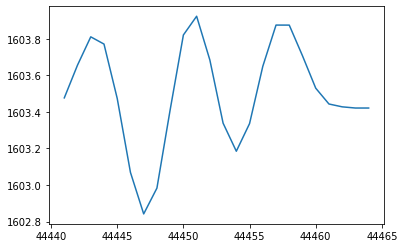

In [99]:
forecast_multivariate['yhat'].iloc[-24:].plot()

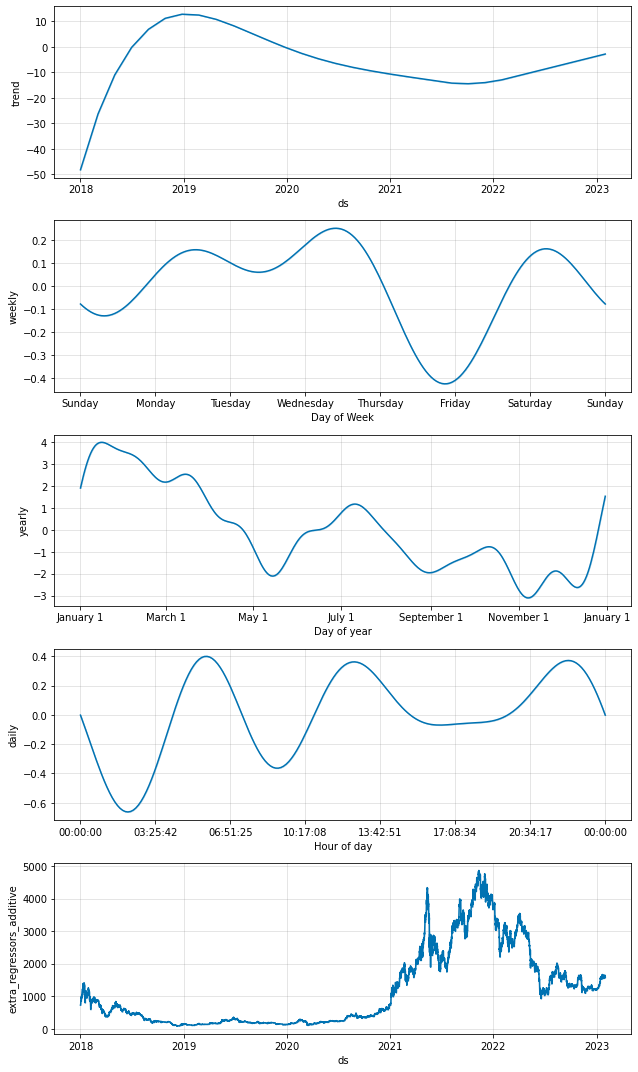

In [26]:
model_multivariate.plot_components(forecast_multivariate);

In [27]:
performance_multivariate = pd.merge(df, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][:-24], on='ds')
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the seasonality model is {performance_multivariate_MAE}')
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the seasonality model is {performance_multivariate_MAPE}')

The MAE for the seasonality model is 10.220234645875957
The MAPE for the seasonality model is 0.023357824813396887


In [28]:
forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-24:]

,ds,yhat,yhat_lower,yhat_upper
44417,2023-01-30 20:00:00,1570.145932,1551.554959,1587.601086
44418,2023-01-30 21:00:00,1563.086071,1545.622645,1583.006795
44419,2023-01-30 22:00:00,1566.476542,1547.842727,1583.665933
44420,2023-01-30 23:00:00,1570.784523,1552.030070,1590.067636
44421,2023-01-31 00:00:00,1575.078899,1556.128684,1594.334366
44422,2023-01-31 01:00:00,1576.674437,1558.317752,1595.318163
44423,2023-01-31 02:00:00,1577.490869,1558.924031,1595.470822
44424,2023-01-31 03:00:00,1577.099504,1559.844301,1594.618082
44425,2023-01-31 04:00:00,1578.420442,1560.288528,1597.390138
44426,2023-01-31 05:00:00,1576.385083,1558.163934,1594.222631


17:33:23 - cmdstanpy - INFO - Chain [1] start processing
17:33:40 - cmdstanpy - INFO - Chain [1] done processing


0                                      New Year's Day
1                          Martin Luther King Jr. Day
2                               Washington's Birthday
3                                        Memorial Day
4                                    Independence Day
5                                           Labor Day
6                                        Columbus Day
7                                        Veterans Day
8                             Veterans Day (Observed)
9                                        Thanksgiving
10                                      Christmas Day
11                        Independence Day (Observed)
12                          New Year's Day (Observed)
13               Juneteenth National Independence Day
14    Juneteenth National Independence Day (Observed)
15                           Christmas Day (Observed)
dtype: object

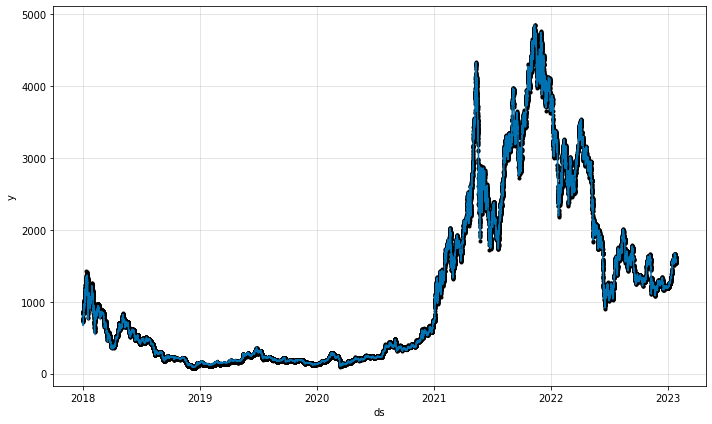

In [59]:
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model_holiday.add_country_holidays(country_name='US')
model_holiday.add_regressor('MA', standardize=False)
model_holiday.fit(df)
future_holiday = model_holiday.make_future_dataframe(periods=24, freq='H')
future_holiday = pd.merge(future_holiday, df[['ds', 'MA']], on='ds', how='inner')
forecast_holiday = model_holiday.predict(future_holiday)
model_holiday.plot(forecast_holiday);
model_holiday.train_holiday_names

In [170]:
# Fit the model on the training dataset
model_holiday.fit(df_train)

00:37:33 - cmdstanpy - INFO - Chain [1] start processing
00:38:08 - cmdstanpy - INFO - Chain [1] done processing


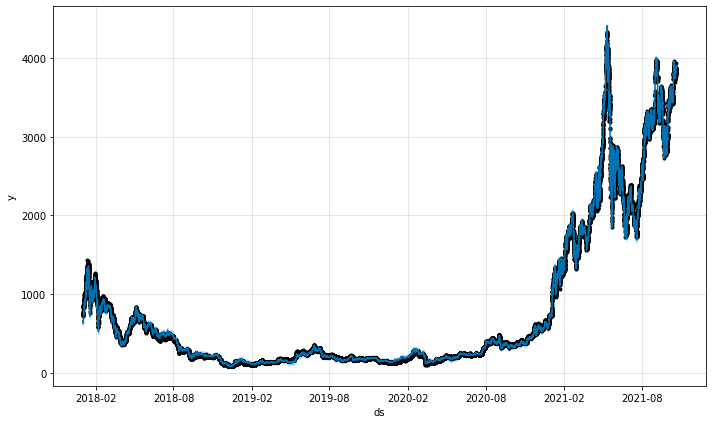

In [171]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=16)
# Append the regressor values
future_holiday = pd.merge(future_holiday, df_train[['ds', 'MA']], on='ds', how='inner')
# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')
# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)
# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

In [181]:
performance_holiday = pd.concat([df_train['y'].reset_index(drop=True),forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index(drop=True)], axis=1)
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the seasonality model is {performance_holiday_MAE}')
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the seasonality model is {performance_holiday_MAPE}')

The MAE for the seasonality model is 16.31778214553784
The MAPE for the seasonality model is 0.04370288676318393


In [183]:
forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01 02:00:00,627.325881,599.600939,656.515918
1,2018-01-01 03:00:00,630.000222,600.667437,658.016036
2,2018-01-01 04:00:00,639.985237,610.905458,667.133727
3,2018-01-01 05:00:00,649.264944,621.438445,678.628653
4,2018-01-01 06:00:00,659.184283,632.017475,689.610890
...,...,...,...,...
33197,2021-10-20 08:00:00,3863.402997,3833.362866,3891.536504
33198,2021-10-20 09:00:00,3873.983263,3843.848002,3898.843587
33199,2021-10-20 10:00:00,3872.419753,3843.359102,3901.443237
33200,2021-10-20 11:00:00,3876.337839,3848.340616,3905.413543


In [117]:
df_train

,ds,y,MA
2,2018-01-01 02:00:00,724.05,723.213333
3,2018-01-01 03:00:00,734.50,725.506667
4,2018-01-01 04:00:00,744.82,734.456667
5,2018-01-01 05:00:00,748.99,742.770000
6,2018-01-01 06:00:00,762.18,751.996667
...,...,...,...
33199,2021-10-20 08:00:00,3850.62,3848.970000
33200,2021-10-20 09:00:00,3868.59,3859.160000
33201,2021-10-20 10:00:00,3853.46,3857.556667
33202,2021-10-20 11:00:00,3861.01,3861.020000


In [184]:
future_holiday = pd.concat([model_holiday.make_future_dataframe(periods=16, freq = '1h'), df_train['MA'].reset_index(drop=True)], axis=1)


In [185]:
future_holiday

,ds,MA
0,2018-01-01 02:00:00,723.213333
1,2018-01-01 03:00:00,725.506667
2,2018-01-01 04:00:00,734.456667
3,2018-01-01 05:00:00,742.770000
4,2018-01-01 06:00:00,751.996667
...,...,...
33213,2021-10-21 00:00:00,NaN
33214,2021-10-21 01:00:00,NaN
33215,2021-10-21 02:00:00,NaN
33216,2021-10-21 03:00:00,NaN


In [187]:
future_holiday = future_holiday.fillna(method='ffill')


In [188]:
forecast_holiday = model_holiday.predict(future_holiday)

<AxesSubplot: >

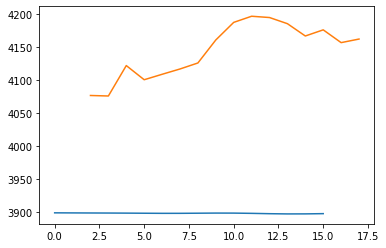

In [199]:
forecast_holiday[-16:].reset_index()['yhat'].plot()
df_test[:16]['y'].plot()

<AxesSubplot: >

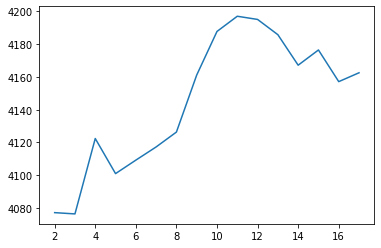

<AxesSubplot: >

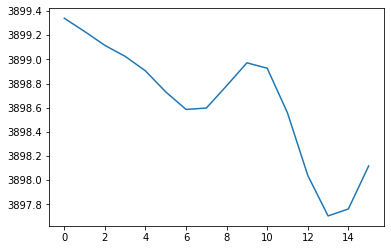

In [200]:
forecast_holiday[-16:].reset_index()['yhat'].plot()

In [ ]:
ajt + features